<a href="https://colab.research.google.com/github/mlaugharn/math189covid19/blob/master/covid_second_wave_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# data sources
# apple maps movement trends
# google maps movement trends
# global policies dataset
# all per state
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
import pprint
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [0]:
# https://en.wikipedia.org/wiki/County_statistics_of_the_United_States#Most_densely_populated

In [71]:
USA = {'Mississippi', 'Virginia', 'South Carolina', 'Massachusetts', 'New Jersey', 'Arkansas', 'Tennessee', 'Hawaii', 'South Dakota', 'Alaska', 'North Dakota', 'Kansas', 'Utah', 'Texas', 'Louisiana', 'District of Columbia', 'Wyoming', 'Oklahoma', 'Pennsylvania', 'Kentucky', 'Connecticut', 'New York', 'Montana', 'Vermont', 'West Virginia', 'Maine', 'Maryland', 'Missouri', 'New Mexico', 'Ohio', 'Illinois', 'Minnesota', 'New Hampshire', 'Oregon', 'Washington', 'Delaware', 'Michigan', 'California', 'Idaho', 'Georgia', 'Nebraska', 'Arizona', 'Florida', 'Alabama', 'North Carolina', 'Colorado', 'Indiana', 'Iowa', 'Wisconsin', 'Nevada', 'Rhode Island'}
def get_apple_data(date = None):
    # focus on driving data
    if date == None: 
        output = {}
        apple_covid_df = pd.read_csv("https://covid19-static.cdn-apple.com/covid19-mobility-data/2007HotfixDev48/v2/en-us/applemobilitytrends-2020-05-04.csv")
        apple_covid_df['region'] = apple_covid_df['region'].replace({'Washington DC': 'District of Columbia'})
        # filter to US regions
        #apple_covid_df = apple_covid_df.iloc[apple_covid_df.index[apple_covid_df['transportation_type'] == 'driving']].reset_index()
        #print(apple_covid_df.index[apple_covid_df['region'].isin(USA)])
        apple_covid_df = apple_covid_df.iloc[apple_covid_df.index[apple_covid_df['region'].isin(USA)]]
        #apple_covid_df = apple_covid_df.drop(columns='geo_type')
        # filter to only driving data
        # dataset currently has 1 date as 1 column
        # now need to make 1 date = 1 row
        apple_covid_df = apple_covid_df.melt(id_vars=['geo_type', 'region', 'alternative_name', 'transportation_type'], var_name='date', value_name='driving_percent')
        apple_covid_df['date'] = pd.to_datetime(apple_covid_df['date'], errors='coerce')
        apple_covid_df = apple_covid_df.iloc[apple_covid_df.index[apple_covid_df['transportation_type'] == 'driving']]
        apple_covid_df['driving_percent'] = (apple_covid_df['driving_percent'].astype(float) - 100) * (1/100.)
        for region, region_df in apple_covid_df.groupby('region'):
            output[region] = region_df
        print(output.keys())
        assert len(output) == 51, "Not 51 regions in Apple data"
        return output
    else: assert False, "date specific data not implemented yet"

def get_google_data(date = None):
    if date == None: 
        google_covid_df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=a88b56a24e1a1e25', dtype={'sub_region_2': str}, parse_dates=['date'], infer_datetime_format=True)
        states_google_covid_df = google_covid_df.iloc[google_covid_df.index[(google_covid_df['country_region_code'] == 'US') & (google_covid_df.sub_region_1.notnull()) & (google_covid_df.sub_region_2.isnull())]]
        cols_to_change = ["retail_and_recreation_percent_change_from_baseline",
                          "grocery_and_pharmacy_percent_change_from_baseline",
                          "parks_percent_change_from_baseline",
                          "transit_stations_percent_change_from_baseline",
                          "workplaces_percent_change_from_baseline",
                          "residential_percent_change_from_baseline"]
        for col_to_change in cols_to_change:
            states_google_covid_df[col_to_change] = states_google_covid_df[col_to_change].astype(float) * (1/100.)
        output = {}
        for region, region_df in states_google_covid_df.groupby('sub_region_1'):
            output[region] = region_df

        assert len(output) == 51, "Not 51 regions in Google data"
        return output
    else: assert False, "date specific data not implemented yet"

def get_covid_act_now_data(date = None):
    if date == None: 
        act_now_df = pd.read_csv("https://data.covidactnow.org/latest/us/states.OBSERVED_INTERVENTION.timeseries.csv", parse_dates=['date', 'lastUpdatedDate'], infer_datetime_format=True)
        act_now_df['RtIndicator'] = act_now_df['RtIndicator'].fillna(method='bfill')
        act_now_df['RtIndicatorCI90'] = act_now_df['RtIndicatorCI90'].fillna(method='bfill')
        output = {}
        for region, region_df in act_now_df.groupby('stateName'): # split into state dfs
            non_future_data = region_df[region_df['date'] <= pd.to_datetime('now')] # remove rows that speculate about future hospital requirements etc.
            output[region] = non_future_data
        assert len(output) == 51, "Not 51 regions in Covid Act Now data" # states + dc
        return output

def get_states_policies_data(date = None):
    '''Here's the methodology:

    0. No or few containment measures in place.

    1. Ban on public gatherings, cancellation of major events and conferences. It’s not always easy to know when a country goes from step 0 to step 1. I’ve used public announcements by the government and looked at major sporting and cultural events in the country and when they became cancelled.

    2. Schools and universities closed. As from the first day of closure, not when the announcement is made. Dates largely match those available from Unesco at the following web address: https://en.unesco.org/themes/education-emergencies/coronavirus-school-closures

    3. Non-essential shops, restaurants and bars closed. As from the first day of closure, not when the announcement is made.

    4. Night curfew/Partial lockdown in place. Applied for part of the day (usually at night) or for broad population categories (eg, people aged over 60).

    5. All-day lockdown. Government requires citizens to shelter in place all day long. Citizens are allowed to come out to buy essential items.

    6. Harsh lockdown. Citizens are not allowed to come out of their home, even to buy essential items.
    '''
    if date == None:
        policies_df = pd.read_csv("https://raw.githubusercontent.com/OlivierLej/Coronavirus_CounterMeasures/master/dataset.csv")
        print(policies_df.head())
        us_policies_df = policies_df.iloc[policies_df.index[policies_df['country_name'] == 'United States']]
        us_policies_df.head()
        outputs = {}
        us_state_abbrev = {
            'AL': 'Alabama',
            'AK': 'Alaska',
            'AZ': 'Arizona',
            'AR': 'Arkansas',
            'CA': 'California',
            'CO': 'Colorado',
            'CT': 'Connecticut',
            'DC': 'District of Columbia',
            'DE': 'Delaware',
            'FL': 'Florida',
            'GA': 'Georgia',
            'HI': 'Hawaii',
            'ID': 'Idaho',
            'IL': 'Illinois',
            'IN': 'Indiana',
            'IA': 'Iowa',
            'KS': 'Kansas',
            'KY': 'Kentucky',
            'LA': 'Louisiana',
            'ME': 'Maine',
            'MD': 'Maryland',
            'MA': 'Massachusetts',
            'MI': 'Michigan',
            'MN': 'Minnesota',
            'MS': 'Mississippi',
            'MO': 'Missouri',
            'MT': 'Montana',
            'NE': 'Nebraska',
            'NV': 'Nevada',
            'NH': 'New Hampshire',
            'NJ': 'New Jersey',
            'NM': 'New Mexico',
            'NY': 'New York',
            'NC': 'North Carolina',
            'ND': 'North Dakota',
            'OH': 'Ohio',
            'OK': 'Oklahoma',
            'OR': 'Oregon',
            'PA': 'Pennsylvania',
            'RI': 'Rhode Island',
            'SC': 'South Carolina',
            'SD': 'South Dakota',
            'TN': 'Tennessee',
            'TX': 'Texas',
            'UT': 'Utah',
            'VT': 'Vermont',
            'VA': 'Virginia',
            'WA': 'Washington',
            'WV': 'West Virginia',
            'WI': 'Wisconsin',
            'WY': 'Wyoming',
        }
        us_policies_df['country_id'] = us_policies_df['country_id'].replace(us_state_abbrev)
        def renamed(colname):
            #eg 20200502_date -> 2020-05-02
            return f'{colname[:4]}-{colname[4:6]}-{colname[6:8]}'
        column_renaming = {datecol: renamed(datecol) for datecol in us_policies_df.columns[1:]}
        
        us_policies_df = us_policies_df.rename(columns=column_renaming)
        us_policies_df = us_policies_df.rename(columns={'country_id': 'state'})
        us_policies_df = us_policies_df.melt(id_vars=['state'], var_name='date', value_name='lockdown_level')
        us_policies_df['date'] = pd.to_datetime(us_policies_df['date'], errors='coerce')
        for region, region_df in us_policies_df.groupby('state'):
            outputs[region] = region_df
        return outputs

def get_health_poverty_data():
    health_poverty_df = pd.read_csv("https://raw.githubusercontent.com/sherirosalia/Health_by_State/master/assets/data/data.csv")
    health_poverty_df = health_poverty_df.drop(columns=['id', 'abbr'])
    health_poverty_df['state'] = health_poverty_df['state'].replace({'Washington D.C.': 'District of Columbia'})
    outputs = {}
    for region, region_df in health_poverty_df.groupby('state'):
        outputs[region] = region_df
    return outputs

def get_density_data():
    density_df = pd.read_csv("https://raw.githubusercontent.com/camillol/cs424p3/master/data/Population-Density%20By%20State.csv")
    density_df = density_df.drop(columns=["GEO.id","GEO.id2"])
    outputs = {}
    for region, region_df in density_df.groupby("GEO.display-label"):
        outputs[region] = region_df
    return outputs



def build_inputs():
    # USA = states + dc
    apple_covid_df = get_apple_data()
    google_covid_df = get_google_data()
    act_now_df = get_covid_act_now_data()
    policies_df = get_states_policies_data()

    health_poverty_df = get_health_poverty_data()
    pop_density_df = get_density_data()
    # convert all datasets into dict of smaller datasets per state
    # per region, get:
    #   1. driving data from apple
    #   2. retail, grocery/pharmacy, parks, transit, workplace, residential data from google
    #   3. hospital beds required, hospital bed capacity, ICU beds in use, ICU beds capacity, 
    #            ventilators in use, ventilator capacity, R_t indicator, R_t 90% CI,
    #            cumulative deaths, cumulative infected, 
    #            cumulative positive tests, cumulative negative tests, 
    #            latitude, longitude from Covid Act Now website
    #   4. get lockdown strictness timeseries
    #   5. poverty data?

    # standard format: 
    # 1. indexed by region name
    # 2. 1 date per row
    # 3. all features = remaining columns of the row
    # per place, use widest range of dates available in all datasets

    # modeling response to change in policy as a 'smeared' impulse response to e.g. unit step instantaneous impulse - people need a few days to adapt their behaviors, but also have a few days prior knowledge before new policies go into place

    # predicting:
    # 1. for different strictness levels, what are the different death/confirmed case predictions
    inputs = {}
    for region in USA: #
        timeseries_frames = [apple_covid_df[region], google_covid_df[region], act_now_df[region], policies_df[region]]
        constant_frames = [health_poverty_df[region], pop_density_df[region]]

        region_joined_df = reduce(lambda left, right: pd.merge(left, right, on='date'), timeseries_frames)
        region_joined_df = region_joined_df.drop(columns=['sub_region_1', 'sub_region_2', 'country_region_code', 'country_region', 'geo_type', 'alternative_name', 'transportation_type', 'intervention', 'fips', 'lastUpdatedDate', 'countryName', 'stateName', 'countyName', 'state'])
        

        # non-timeseries data, eg. constant columns
        for constant_frame in constant_frames:
            for i, col in enumerate(constant_frame.columns):
                if i > 0: region_joined_df[col] = constant_frame[col].sum()
        
        region_joined_df['Rt_90_lower_bound'] = region_joined_df['RtIndicator'] - (region_joined_df['RtIndicatorCI90'])
        region_joined_df['Rt_90_upper_bound'] = region_joined_df['RtIndicator'] + (region_joined_df['RtIndicatorCI90'])
        region_joined_df['cumulativePositiveTests'] = region_joined_df['cumulativePositiveTests'].fillna(method='bfill')
        region_joined_df['cumulativeNegativeTests'] = region_joined_df['cumulativeNegativeTests'].fillna(method='bfill')
        region_joined_df['positive_test_rate'] = region_joined_df['cumulativePositiveTests'] / (region_joined_df['cumulativePositiveTests'] + region_joined_df['cumulativeNegativeTests'])
        region_joined_df['positive_test_rate'] = region_joined_df['positive_test_rate'].fillna(method='bfill')
        inputs[region] = region_joined_df
    return inputs

def build_model(statename):
    # try to predict R_t of each day
    # for t in days: multiply current # cases by R_t for that day
    # do an exponential model given R_t
    pass

inputs = build_inputs()
for region, region_df in inputs.items():
    region_df.to_csv(open(f'{region}.csv', 'w'), index=False)
    print(f"wrote {region}.csv")

dict_keys(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  country_id country_name  ...  20200606_date  20200607_date
0        AFG  Afghanistan  ...              4              4
1        ALB      Albania  ...              5              5
2        DZA      Algeria  ...              2              2
3        AND      Andorra  ...              5              5
4        AGO       Angola  ...              3              3

[5 rows x 139 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


wrote Delaware.csv
wrote Colorado.csv
wrote Connecticut.csv
wrote Virginia.csv
wrote Minnesota.csv
wrote Alaska.csv
wrote Arizona.csv
wrote Vermont.csv
wrote Wisconsin.csv
wrote Oregon.csv
wrote Wyoming.csv
wrote New York.csv
wrote Washington.csv
wrote South Dakota.csv
wrote Nebraska.csv
wrote Rhode Island.csv
wrote Missouri.csv
wrote Illinois.csv
wrote North Carolina.csv
wrote Texas.csv
wrote Arkansas.csv
wrote North Dakota.csv
wrote Louisiana.csv
wrote Pennsylvania.csv
wrote Michigan.csv
wrote Idaho.csv
wrote Nevada.csv
wrote Montana.csv
wrote District of Columbia.csv
wrote West Virginia.csv
wrote Ohio.csv
wrote Utah.csv
wrote South Carolina.csv
wrote Maine.csv
wrote Kentucky.csv
wrote Florida.csv
wrote New Hampshire.csv
wrote Hawaii.csv
wrote Maryland.csv
wrote New Mexico.csv
wrote Oklahoma.csv
wrote Kansas.csv
wrote Alabama.csv
wrote Indiana.csv
wrote New Jersey.csv
wrote Georgia.csv
wrote Iowa.csv
wrote Tennessee.csv
wrote Massachusetts.csv
wrote Mississippi.csv
wrote California.c

In [72]:
inputs['Alabama'].head()

,region,date,driving_percent,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,hospitalBedsRequired,hospitalBedCapacity,ICUBedsInUse,ICUBedCapacity,ventilatorsInUse,ventilatorCapacity,RtIndicator,RtIndicatorCI90,cumulativeDeaths,cumulativeInfected,cumulativePositiveTests,cumulativeNegativeTests,lat,long,lockdown_level,poverty,povertyMoe,age,ageMoe,income,incomeMoe,healthcare,healthcareLow,healthcareHigh,obesity,obesityLow,obesityHigh,smokes,smokesLow,smokesHigh,Density per square mile of land area,Rt_90_lower_bound,Rt_90_upper_bound,positive_test_rate
0,Alabama,2020-03-03,0.1538,0.20,0.15,0.33,0.05,0.02,-0.01,0,15870,0,465,0,1551,1.5,4.0,0,6,0.0,0.0,32.539527,-86.644082,0,19.3,0.5,38.6,0.2,42830,598,13.9,12.7,15.1,33.5,32.1,35.0,21.1,19.8,22.5,94.4,-2.5,5.5,0.0
1,Alabama,2020-03-04,0.1090,0.07,0.00,-0.08,0.02,0.00,0.01,0,15870,0,465,0,1551,1.5,4.0,0,15,0.0,0.0,32.539527,-86.644082,0,19.3,0.5,38.6,0.2,42830,598,13.9,12.7,15.1,33.5,32.1,35.0,21.1,19.8,22.5,94.4,-2.5,5.5,0.0
2,Alabama,2020-03-05,0.2409,0.07,0.06,0.00,0.04,0.02,0.01,0,15870,0,465,0,1551,1.5,4.0,0,25,0.0,0.0,32.539527,-86.644082,0,19.3,0.5,38.6,0.2,42830,598,13.9,12.7,15.1,33.5,32.1,35.0,21.1,19.8,22.5,94.4,-2.5,5.5,0.0
3,Alabama,2020-03-06,0.5782,0.09,0.04,0.29,0.10,0.02,-0.01,0,15870,0,465,0,1551,1.5,4.0,0,38,0.0,0.0,32.539527,-86.644082,0,19.3,0.5,38.6,0.2,42830,598,13.9,12.7,15.1,33.5,32.1,35.0,21.1,19.8,22.5,94.4,-2.5,5.5,0.0
4,Alabama,2020-03-07,0.5873,0.12,0.08,0.63,0.18,0.07,-0.02,0,15870,0,465,0,1551,1.5,4.0,0,55,0.0,0.0,32.539527,-86.644082,0,19.3,0.5,38.6,0.2,42830,598,13.9,12.7,15.1,33.5,32.1,35.0,21.1,19.8,22.5,94.4,-2.5,5.5,0.0


In [73]:
params = ['driving_percent', 'retail_and_recreation_percent_change_from_baseline', 
          'grocery_and_pharmacy_percent_change_from_baseline', 
          'transit_stations_percent_change_from_baseline',
          'workplaces_percent_change_from_baseline', 
          'residential_percent_change_from_baseline', 
          'lockdown_level', 'poverty', 'age', 'income',
          'healthcare', 'healthcareLow', 'healthcareHigh',
          'obesity', 'smokes', 'smokesLow', 'smokesHigh',
          'Density per square mile of land area']
X = inputs['Alabama'][params].values
X = np.hstack((X, np.arange(len(X)).reshape((-1,1))))
y = inputs['Alabama'][['RtIndicator']].values
print(X.shape,y.shape)
reg = LinearRegression(normalize=True).fit(X, y)
reg.score(X,y)

(59, 19) (59, 1)


0.9230854352759202

In [74]:
regression_coefs = {param: [] for param in params + ['t', 't^2']}
intercepts = []
#X_tot = None
#y_tot = np.array([])
for region in USA:
    #print(f"cols with nans: {inputs[region][params].columns[inputs[region][params].isna().any()].tolist()}")
    X = inputs[region][params].values
    t = np.arange(len(X)).reshape((-1,1))
    X = np.hstack((X, t, np.square(t)))
    
    #y = np.diff(np.log(inputs[region][['cumulativeDeaths']].values + 1e-9), axis=0)
    y = inputs[region][['RtIndicator']].values.ravel()
    
    # if type(X_tot) == type(None): X_tot = X
    # else: 
    #     print(X_tot.shape, X.shape)
    #     X_tot = np.concatenate((X_tot, X), axis=0)
    # y_tot = np.hstack((y_tot,y))

    #X_tot = preprocessing.StandardScaler().fit(X_tot).transform(X_tot)
    X = preprocessing.StandardScaler().fit(X).transform(X)
    reg = SGDRegressor(max_iter=100000).fit(X, y)
    
    print(f"regression for {region}")
    print(reg.score(X,y))
    # pprint.pprint({param:reg.coef_[0][i] for i, param in enumerate(params + ['t'])})
    for i, param in enumerate(params + ['t', 't^2']):
        regression_coefs[param].append(reg.coef_[i])
        intercepts.append(reg.intercept_)

print(f"b={sum(intercepts)/len(intercepts)}")
for i, param in enumerate(regression_coefs):
    coefs = regression_coefs[param]
    if len(coefs) > 0:
        print(f"{param}: \n\t median = {np.median(coefs)} \n\t min = {np.min(coefs)} \n\t mean = {np.mean(coefs)} \n\t max = {np.max(coefs)} \n")

regression for Delaware
0.8731869999880039
regression for Colorado
0.7743161499462468
regression for Connecticut
0.8881515600832239
regression for Virginia
0.8284482429841145
regression for Minnesota
0.5723786209447577
regression for Alaska
0.8360716823109625
regression for Arizona
0.7661292763804518
regression for Vermont
0.8507069609082836
regression for Wisconsin
0.7081802926990274
regression for Oregon
0.8800135227684488
regression for Wyoming
0.8125230638124075
regression for New York
0.8326037106496821
regression for Washington
0.9242709101481564
regression for South Dakota
0.7736359279622886
regression for Nebraska
0.6899277712466108
regression for Rhode Island
0.9296409546669744
regression for Missouri
0.8480653043119868
regression for Illinois
0.773083354791147
regression for North Carolina
0.8264514306384676
regression for Texas
0.9123619201359536
regression for Arkansas
0.6424130219773607
regression for North Dakota
0.698157037286299
regression for Louisiana
0.77957217994572

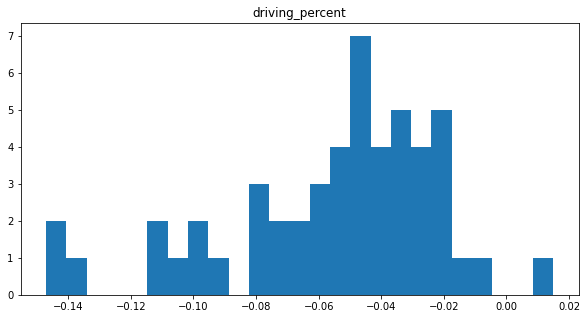

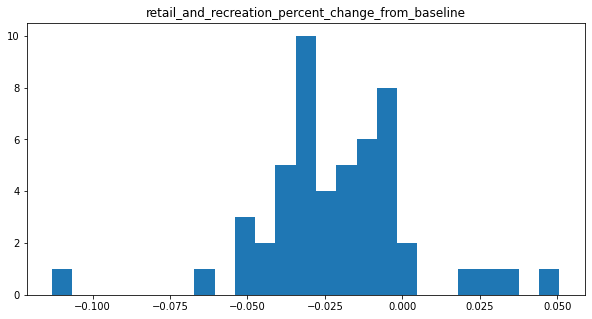

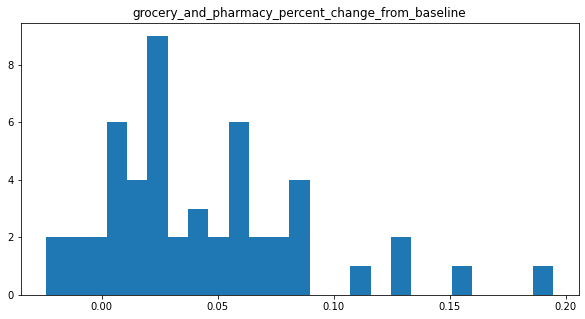

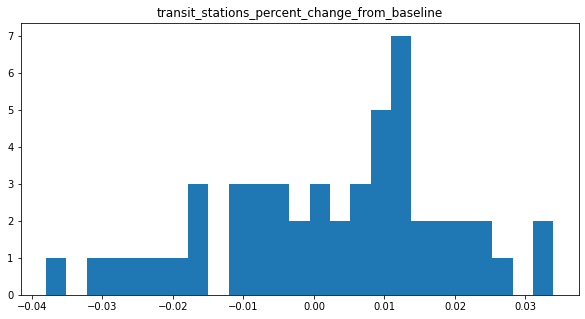

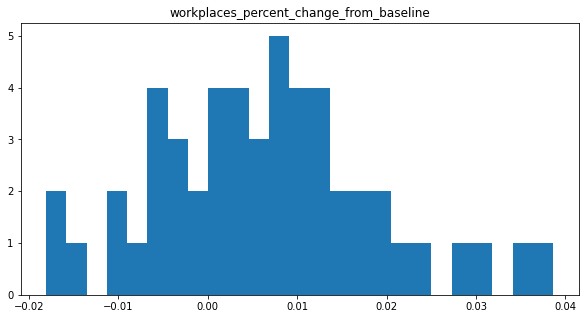

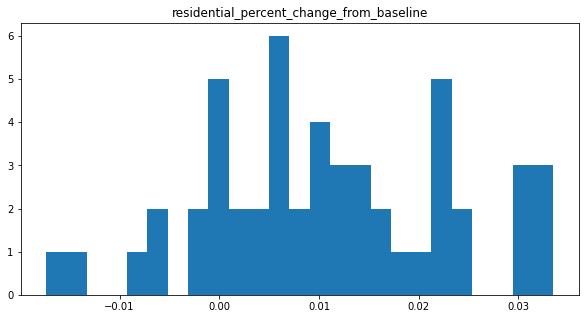

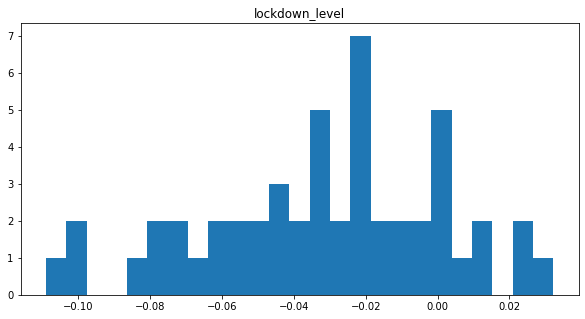

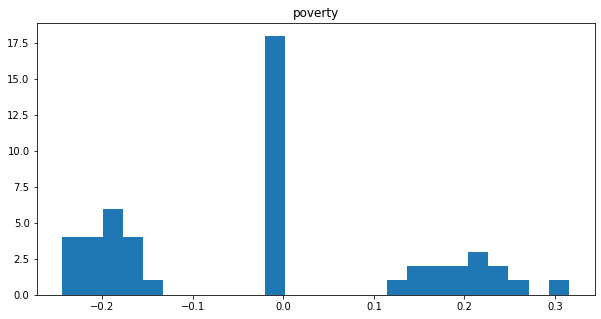

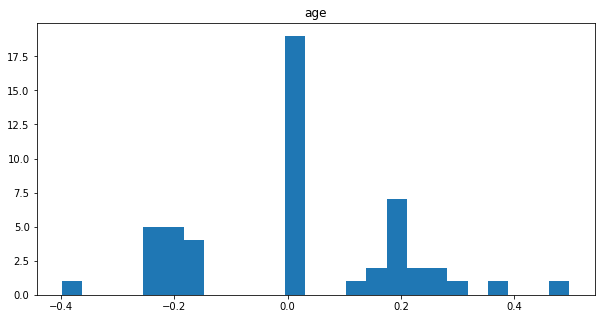

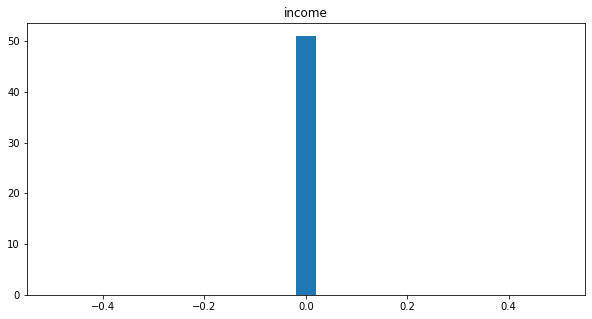

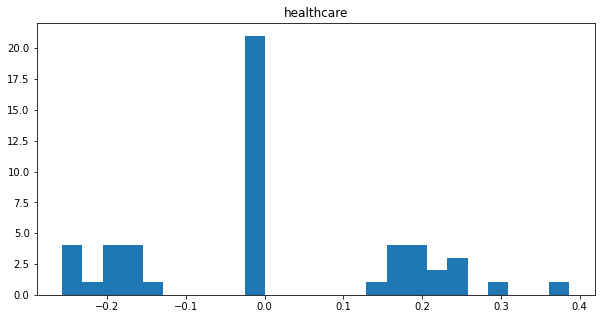

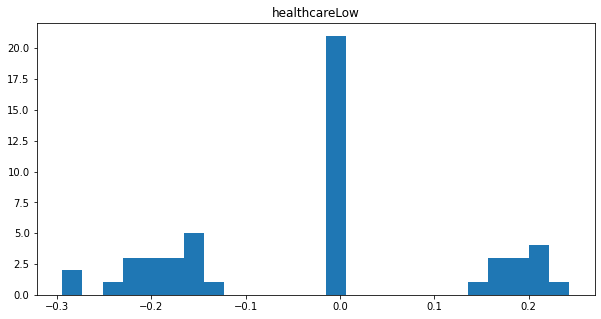

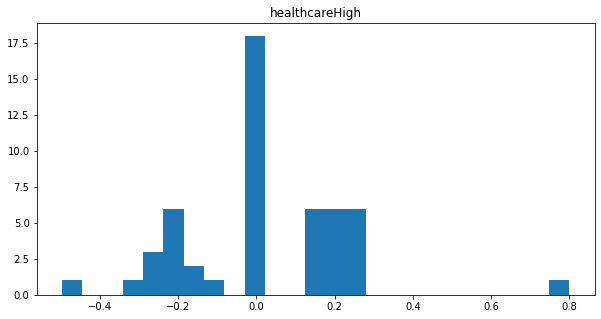

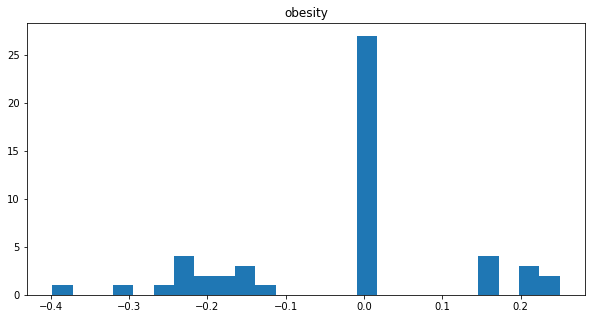

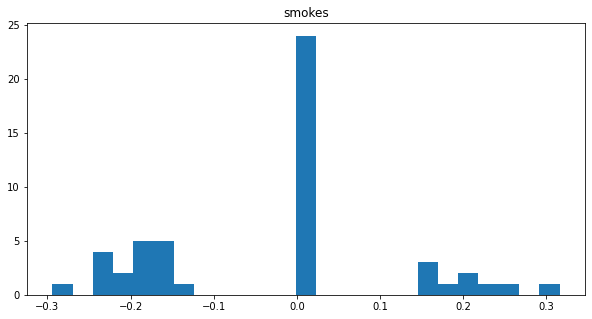

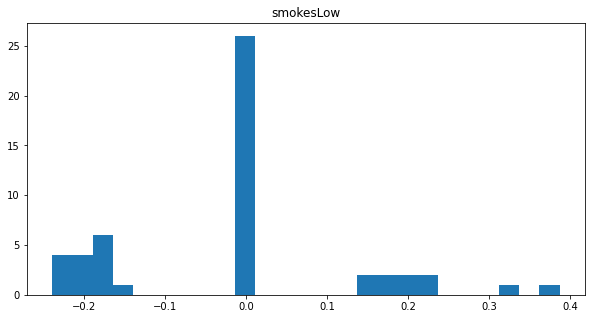

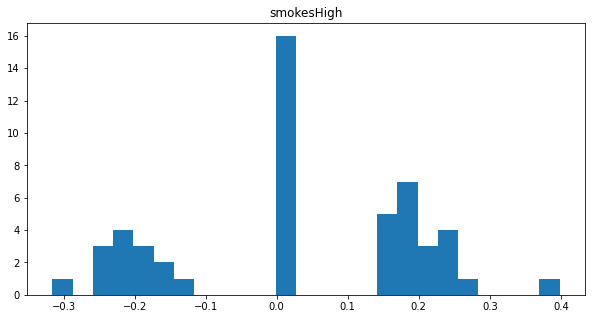

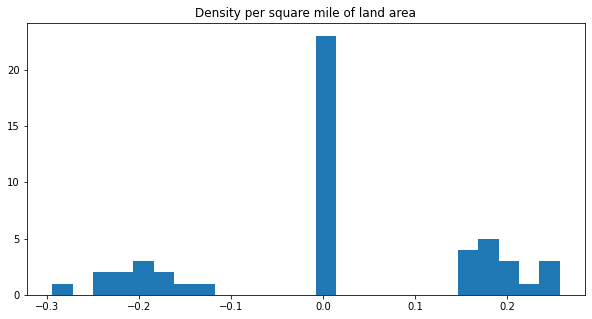

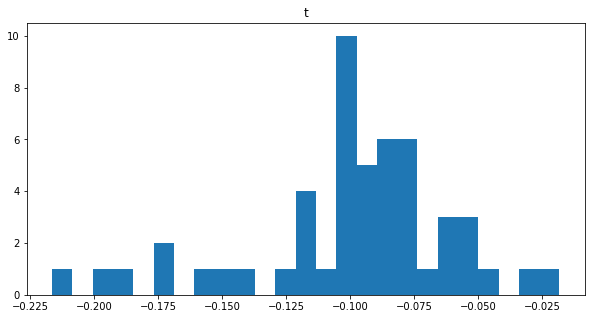

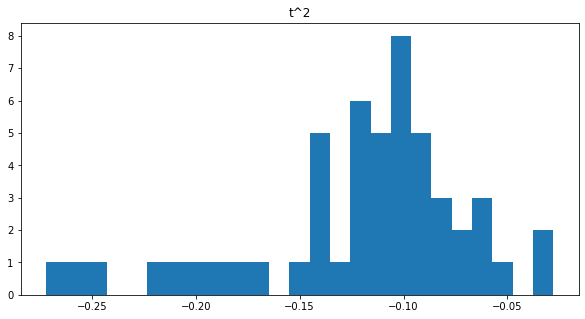

In [75]:

for i, param in enumerate(params + ['t', 't^2']):
    plt.figure(figsize=(10,5))
    plt.hist(regression_coefs[param], bins=25)
    plt.title(param)
    plt.show()

    prev_hidden                              ----------> |i2o| ---------------> output
        +        -----> |input2hidden1| -----|
      input                                  ----------> |input2hidden2|------> hidden

In [0]:

import torch.nn.functional as F
class LSTM(nn.Module):
    # adapted from https://www.jessicayung.com/lstms-for-time-series-in-pytorch/
    def __init__(self, input_dim, hidden_dim1, seq_len=14, output_dim = 2, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.output_dim = output_dim
        self.seq_len = seq_len

        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim1, self.num_layers, dropout=0.15)

        # define output layer
        self.linear1 = nn.Linear(self.hidden_dim1, self.output_dim)
        #self.linear2 = nn.Linear(self.hidden_dim2, self.output_dim)

    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.seq_len, self.hidden_dim1),
                torch.zeros(self.num_layers, self.seq_len, self.hidden_dim1))
    
    def forward(self, input):
        # lstm_out shape: [input_size, batch_size, hidden_dim]
        # self.hidden shape: (a, b)
        # where a and b both have shape (num_layers, batch_size, hidden_dim)
        #print(input.shape)
        lstm_out, self.hidden = self.lstm(
            input.reshape(len(input), self.seq_len, -1))
        y_pred = F.softplus(self.linear1(lstm_out.view(self.seq_len, len(input), -1)[-1]))
        return y_pred.reshape((-1, self.output_dim))


def sliding_windows(X, Y, seq_length):
    xs = []
    ys = []
    for i in range(len(X) - seq_length - 1):
        x = X[i:(i+seq_length)]
        y = Y[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.from_numpy(np.array(xs)), torch.from_numpy(np.array(ys))




In [0]:
def build_state_model(region):
    print(f"starting {region}")
    input_params = [
        'driving_percent', 'retail_and_recreation_percent_change_from_baseline', 
        'grocery_and_pharmacy_percent_change_from_baseline', 
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline', 
        'residential_percent_change_from_baseline', 
        'lockdown_level', 'lat', 'long', 
        'hospitalBedsRequired', 'hospitalBedCapacity',
        'ICUBedsInUse', 'ICUBedCapacity',
        'poverty', 'age', 'income',
        'healthcare', 'healthcareLow', 'healthcareHigh',
        'obesity', 'smokes', 'smokesLow', 'smokesHigh',
        'Density per square mile of land area',
        'positive_test_rate',
        'cumulativeDeaths', 'cumulativeInfected', 
        'cumulativePositiveTests', 'cumulativeNegativeTests']
    output_params = ['RtIndicator', ]
    seq_len = 4

    X = inputs[region][input_params].values.astype('float32')
    X = preprocessing.StandardScaler().fit(X).transform(X)
    Y = inputs[region][output_params].values.astype('float32')
    
    test_size = 8
    
    X_train, X_test = X[:-test_size], X[-test_size:]
    Y_train, Y_test = Y[:-test_size], Y[test_size:]

    X_train_lstm, y_train_lstm = sliding_windows(X_train, Y_train, seq_len)
    X_test_lstm, y_test_lstm = sliding_windows(X_test, Y_test, seq_len)
    
    hidden1 = 2
    print(len(input_params))
    model = LSTM(len(input_params), hidden_dim1 = hidden1, seq_len = seq_len, output_dim = len(output_params), num_layers=3)

    loss_fn = torch.nn.MSELoss(reduction='mean')
    learning_rate = 1e-3
    num_epochs = 500
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    #####################
    # Train model
    #####################
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    train_losses = [] 
    test_losses = []
    for t in range(num_epochs):
        # Clear stored gradient

        model.zero_grad()
        
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()
        
        # Forward pass
        y_pred = model(X_train_lstm)
    
        train_loss = loss_fn(y_pred, y_train_lstm)
        train_losses.append(train_loss)
        
        with torch.no_grad():
            y_test_pred = model(X_test_lstm)
            test_loss = loss_fn(y_test_pred, y_test_lstm)
        test_hist[t] = test_loss.item()
        train_hist[t] = train_loss.item()
    
        if t % 50 == 0:
            print("Epoch ", t, "train MSE: ", train_loss.item(), "test MSE: ", test_loss.item())

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
        # Update parameters
        optimiser.step()
    plt.plot(train_losses)
    plt.title(f'{region} loss curve')
    plt.show()
    print("prediction vs actual:")
    pprint.pprint(list(zip(y_test_pred.data, y_test_lstm)))
    timespan = list(range(1, len(y_test_pred.data)))
    extrapolation = extrapolate_r0(y_test_pred.data[-1], current_population=inputs[region]['cumulativeInfected'].values[-1], timespan=timespan)
    prev_values = inputs[region]['cumulativeInfected']
    series = np.hstack((prev_values,extrapolation.data.numpy()))
    print(series)
    plt.plot(series)
    plt.title(f"{region} w/ {len(timespan)}-day forecast: r0 = {y_test_pred.data[-1][0]}")
    plt.show()
    return model


starting Delaware
29
Epoch  0 train MSE:  0.6945884227752686 test MSE:  0.8072509765625
Epoch  50 train MSE:  0.5174965858459473 test MSE:  0.621771514415741
Epoch  100 train MSE:  0.29717615246772766 test MSE:  0.41604945063591003
Epoch  150 train MSE:  0.11098417639732361 test MSE:  0.2341148853302002
Epoch  200 train MSE:  0.02883969433605671 test MSE:  0.1447874754667282
Epoch  250 train MSE:  0.021225811913609505 test MSE:  0.09720448404550552
Epoch  300 train MSE:  0.015509597025811672 test MSE:  0.10503564029932022
Epoch  350 train MSE:  0.015602079220116138 test MSE:  0.11594649404287338
Epoch  400 train MSE:  0.01336932834237814 test MSE:  0.09074314683675766
Epoch  450 train MSE:  0.010507872328162193 test MSE:  0.07231675833463669


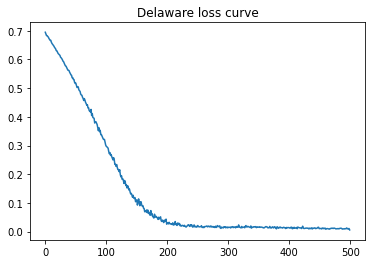

prediction vs actual:
[(tensor([1.2852]), tensor([1.5600])),
 (tensor([1.2679]), tensor([1.5600])),
 (tensor([1.2749]), tensor([1.5500]))]
[0.00000000e+00 5.00000000e+00 1.10000000e+01 2.00000000e+01
 3.00000000e+01 4.30000000e+01 6.00000000e+01 8.10000000e+01
 1.07000000e+02 1.40000000e+02 1.82000000e+02 2.35000000e+02
 3.01000000e+02 3.86000000e+02 4.92000000e+02 6.26000000e+02
 7.95000000e+02 1.00800000e+03 1.27700000e+03 1.61600000e+03
 2.04400000e+03 2.58300000e+03 3.25700000e+03 4.08500000e+03
 5.08300000e+03 6.26600000e+03 7.64700000e+03 9.23100000e+03
 1.10210000e+04 1.30070000e+04 1.51710000e+04 1.74790000e+04
 1.99100000e+04 2.23920000e+04 2.48780000e+04 2.73150000e+04
 2.96710000e+04 3.19710000e+04 3.42450000e+04 3.65070000e+04
 3.87640000e+04 4.10210000e+04 4.32790000e+04 4.55380000e+04
 4.77990000e+04 5.00620000e+04 5.23250000e+04 5.45880000e+04
 5.68510000e+04 5.91120000e+04 6.13710000e+04 6.36280000e+04
 6.58820000e+04 6.81310000e+04 7.03750000e+04 7.26140000e+04
 7.4846

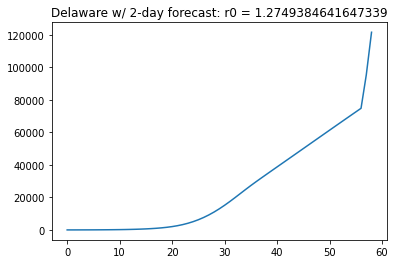

starting Colorado
29
Epoch  0 train MSE:  0.2645373046398163 test MSE:  0.41140785813331604
Epoch  50 train MSE:  0.14366821944713593 test MSE:  0.26479747891426086
Epoch  100 train MSE:  0.09621715545654297 test MSE:  0.1762385368347168
Epoch  150 train MSE:  0.0846317782998085 test MSE:  0.146959125995636
Epoch  200 train MSE:  0.06981176137924194 test MSE:  0.1561269313097
Epoch  250 train MSE:  0.04413725063204765 test MSE:  0.1748611181974411
Epoch  300 train MSE:  0.021737288683652878 test MSE:  0.23354391753673553
Epoch  350 train MSE:  0.013792683370411396 test MSE:  0.28872278332710266
Epoch  400 train MSE:  0.014764553867280483 test MSE:  0.3382030725479126
Epoch  450 train MSE:  0.014620554633438587 test MSE:  0.3484286069869995


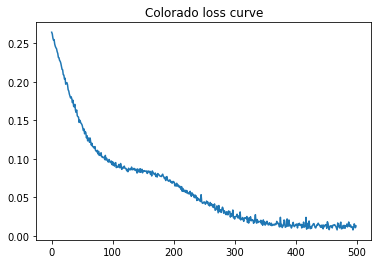

prediction vs actual:
[(tensor([1.0967]), tensor([1.7200])),
 (tensor([1.1615]), tensor([1.7200])),
 (tensor([1.1133]), tensor([1.7200]))]
[9.40000000e+01 1.29000000e+02 1.75000000e+02 2.35000000e+02
 3.13000000e+02 4.15000000e+02 5.47000000e+02 7.18000000e+02
 9.41000000e+02 1.23000000e+03 1.60600000e+03 2.09500000e+03
 2.72900000e+03 3.55400000e+03 4.62600000e+03 6.01800000e+03
 7.81900000e+03 1.01000000e+04 1.29330000e+04 1.63900000e+04
 2.05330000e+04 2.54150000e+04 3.10570000e+04 3.74500000e+04
 4.45600000e+04 5.22980000e+04 6.04590000e+04 6.90720000e+04
 7.77040000e+04 8.61950000e+04 9.43820000e+04 1.02332000e+05
 1.10170000e+05 1.17960000e+05 1.25740000e+05 1.33531000e+05
 1.41340000e+05 1.49172000e+05 1.57028000e+05 1.64908000e+05
 1.72812000e+05 1.80739000e+05 1.88687000e+05 1.96656000e+05
 2.04645000e+05 2.12651000e+05 2.20674000e+05 2.28711000e+05
 2.36763000e+05 2.44825000e+05 2.52897000e+05 2.60977000e+05
 2.69063000e+05 2.77154000e+05 2.85248000e+05 2.93344000e+05
 3.0144

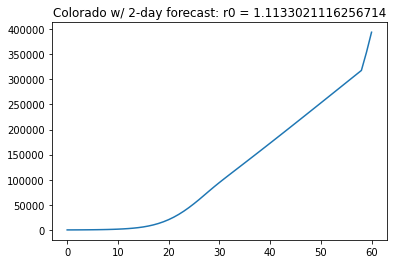

starting Connecticut
29
Epoch  0 train MSE:  0.6512888669967651 test MSE:  0.8626305460929871
Epoch  50 train MSE:  0.5686019659042358 test MSE:  0.7752874493598938
Epoch  100 train MSE:  0.4800768792629242 test MSE:  0.6690489649772644
Epoch  150 train MSE:  0.38532355427742004 test MSE:  0.565683126449585
Epoch  200 train MSE:  0.306645005941391 test MSE:  0.46628427505493164
Epoch  250 train MSE:  0.23017844557762146 test MSE:  0.365252822637558
Epoch  300 train MSE:  0.16140250861644745 test MSE:  0.2642322778701782
Epoch  350 train MSE:  0.11842275410890579 test MSE:  0.20332948863506317
Epoch  400 train MSE:  0.10313799977302551 test MSE:  0.1585315614938736
Epoch  450 train MSE:  0.09956277161836624 test MSE:  0.13681983947753906


KeyboardInterrupt: ignored

In [175]:
models = {}
for region in USA:
    models[region] = build_state_model(region)

starting California
29
Epoch  0 train MSE:  1.3100827932357788 test MSE:  0.5734129548072815
Epoch  50 train MSE:  1.0145050287246704 test MSE:  0.4302370548248291
Epoch  100 train MSE:  0.5849700570106506 test MSE:  0.2572646141052246
Epoch  150 train MSE:  0.18481625616550446 test MSE:  0.06852581351995468
Epoch  200 train MSE:  0.0629415512084961 test MSE:  0.014877255074679852
Epoch  250 train MSE:  0.059719957411289215 test MSE:  0.04686730355024338
Epoch  300 train MSE:  0.0543953999876976 test MSE:  0.02695322409272194
Epoch  350 train MSE:  0.06263114511966705 test MSE:  0.025503814220428467
Epoch  400 train MSE:  0.061205632984638214 test MSE:  0.032639820128679276
Epoch  450 train MSE:  0.061479952186346054 test MSE:  0.01636568270623684


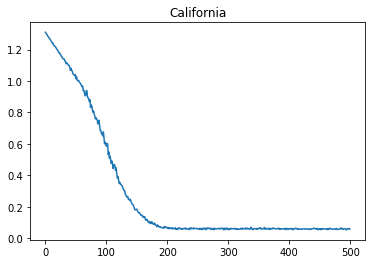

prediction vs actual:
[(tensor([1.2808]), tensor([1.3100])),
 (tensor([1.1784]), tensor([1.2800])),
 (tensor([1.2528]), tensor([1.2500])),
 (tensor([1.1755]), tensor([1.2200])),
 (tensor([1.0422]), tensor([1.1900])),
 (tensor([1.1824]), tensor([1.1800])),
 (tensor([1.0686]), tensor([1.1400]))]


LSTM(
  (lstm): LSTM(29, 5, num_layers=3, dropout=0.5)
  (linear1): Linear(in_features=5, out_features=1, bias=True)
)

In [141]:
build_state_model('California')

In [0]:
inputs['Colorado'].tail(n=22)

all columns available: Index(['region', 'date', 'driving_percent',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'hospitalBedsRequired',
       'hospitalBedCapacity', 'ICUBedsInUse', 'ICUBedCapacity',
       'ventilatorsInUse', 'ventilatorCapacity', 'RtIndicator',
       'RtIndicatorCI90', 'cumulativeDeaths', 'cumulativeInfected',
       'cumulativePositiveTests', 'cumulativeNegativeTests', 'lat', 'long',
       'lockdown_level', 'poverty', 'povertyMoe', 'age', 'ageMoe', 'income',
       'incomeMoe', 'healthcare', 'healthcareLow', 'healthcareHigh', 'obesity',
       'obesityLow', 'obesityHigh', 'smokes', 'smokesLow', 'smokesHigh',
       'Density per square mile of land area', 'Rt_90_lower_bound',
       'Rt_90_up

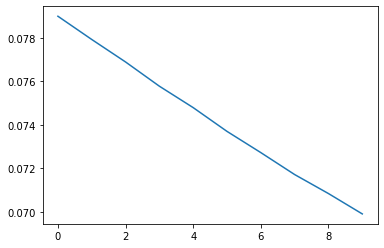

prediction vs actual:
[(tensor([0.4983]), tensor([0.4447])),
 (tensor([0.4969]), tensor([0.4187])),
 (tensor([0.4998]), tensor([0.3988])),
 (tensor([0.4906]), tensor([0.3853])),
 (tensor([0.4965]), tensor([0.3577])),
 (tensor([0.5029]), tensor([0.3436])),
 (tensor([0.5022]), tensor([0.3365]))]
driving_percent: 0.2711464762687683
retail_and_recreation_percent_change_from_baseline: 0.2626262307167053
grocery_and_pharmacy_percent_change_from_baseline: 0.4363636374473572
transit_stations_percent_change_from_baseline: 0.28318583965301514
workplaces_percent_change_from_baseline: 0.2592592239379883
residential_percent_change_from_baseline: 0.4444444179534912
lockdown_level: 1.0
lat: 0.43431082367897034
long: 0.3941535949707031
hospitalBedsRequired: 0.27413904666900635
hospitalBedCapacity: 0.9999999403953552
ICUBedsInUse: 0.20085731148719788
ICUBedCapacity: 1.0
poverty: 0.5853658318519592
age: 0.40441179275512695
income: 0.6489458084106445
healthcare: 0.5024631023406982
healthcareLow: 0.497461

In [135]:
input_params = [
        'driving_percent', 'retail_and_recreation_percent_change_from_baseline', 
        'grocery_and_pharmacy_percent_change_from_baseline', 
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline', 
        'residential_percent_change_from_baseline', 
        'lockdown_level', 'lat', 'long', 
        'hospitalBedsRequired', 'hospitalBedCapacity',
        'ICUBedsInUse', 'ICUBedCapacity',
        'poverty', 'age', 'income',
        'healthcare', 'healthcareLow', 'healthcareHigh',
        'obesity', 'smokes', 'smokesLow', 'smokesHigh',
        'Density per square mile of land area',
        'positive_test_rate',
        'cumulativeDeaths', 'cumulativeInfected', 
        'cumulativePositiveTests', 'cumulativeNegativeTests'] + [f'state{i}' for i in range(len(USA))]

inputs_USA = []
for i, (region, region_df) in enumerate(inputs.items()):
    for statenumbervec in range(len(USA)):
        region_df[f"state{statenumbervec}"] = 0
    region_df[f'state{i}'] = 1
    inputs_USA.append(region_df)
inputs_USA = pd.concat(inputs_USA, ignore_index=True)
print(f"all columns available: {inputs_USA.columns}")
print(f"input params: {input_params}")
output_params = ['RtIndicator']
print(f"output params: {output_params}")
seq_len = 12
X = inputs_USA[input_params].values.astype('float32')
X = preprocessing.MinMaxScaler().fit(X).transform(X)
Y = np.log(inputs_USA[output_params].values.astype('float32'))
test_size = 20

X_train, X_test = X[:-test_size], X[-test_size:]
Y_train, Y_test = Y[:-test_size], Y[test_size:]

X_train_lstm, y_train_lstm = sliding_windows(X_train, Y_train, seq_len)
X_test_lstm, y_test_lstm = sliding_windows(X_test, Y_test, seq_len)

hidden1 = 5
print(len(input_params))
model = LSTM(len(input_params), hidden_dim1 = hidden1, seq_len = seq_len, output_dim = len(output_params), num_layers=3)

loss_fn = torch.nn.MSELoss(reduction='mean')
learning_rate = 1.5e-3
num_epochs = 10
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

#####################
# Train model
#####################

train_hist = np.zeros(num_epochs)
test_hist = np.zeros(num_epochs)
train_losses = [] 
test_losses = []
for t in range(num_epochs):
    # Clear stored gradient

    model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train_lstm)

    train_loss = loss_fn(y_pred, y_train_lstm)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        y_test_pred = model(X_test_lstm)
        test_loss = loss_fn(y_test_pred, y_test_lstm)
    test_hist[t] = test_loss.item()
    train_hist[t] = train_loss.item()

    if t % 2 == 0:
        print("Epoch ", t, "train MSE: ", train_loss.item(), "test MSE: ", test_loss.item())

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    train_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 100)
    # Update parameters
    optimiser.step()
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()
print("prediction vs actual:")
pprint.pprint(list(zip(y_test_pred.data, y_test_lstm)))
for i, input_param in enumerate(input_params):
    print(f"{input_param}: {X_test_lstm[-1, -1, i]}")


In [0]:
{param: X_lstm[-1][-1][i] for i, param in enumerate(params)}

{'Density per square mile of land area': tensor(0.),
 'age': tensor(0.),
 'driving_percent': tensor(-0.0139),
 'grocery_and_pharmacy_percent_change_from_baseline': tensor(-0.2063),
 'healthcare': tensor(0.),
 'healthcareHigh': tensor(0.),
 'healthcareLow': tensor(0.),
 'income': tensor(0.),
 'lockdown_level': tensor(0.6364),
 'obesity': tensor(0.),
 'poverty': tensor(0.),
 'residential_percent_change_from_baseline': tensor(0.0215),
 'retail_and_recreation_percent_change_from_baseline': tensor(-0.4084),
 'smokes': tensor(0.),
 'smokesHigh': tensor(0.),
 'smokesLow': tensor(0.),
 'transit_stations_percent_change_from_baseline': tensor(-0.4709),
 'workplaces_percent_change_from_baseline': tensor(-0.6537)}

In [0]:
#import gc; gc.collect()
X_lstm[-1]

tensor([[0.0855, 0.2353, 0.2500, 0.0921, 0.0833, 0.8182, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0983, 0.2353, 0.2778, 0.0921, 0.0694, 0.8182, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1207, 0.2706, 0.3611, 0.1184, 0.0694, 0.8182, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1187, 0.2471, 0.3333, 0.0921, 0.0556, 0.8485, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1503, 0.2118, 0.3056, 0.0789, 0.0556, 0.9394, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1308, 0.2000, 0.3194, 0.1447, 0.2639, 0.5758, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0431, 0.188

In [0]:
params

['driving_percent',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline',
 'lockdown_level',
 'poverty',
 'age',
 'income',
 'healthcare',
 'healthcareLow',
 'healthcareHigh',
 'obesity',
 'smokes',
 'smokesLow',
 'smokesHigh',
 'Density per square mile of land area']

(array([ 5.,  5., 10.,  9.,  3.,  5.,  5.,  2.,  3.,  4.]),
 array([39680. , 43109.1, 46538.2, 49967.3, 53396.4, 56825.5, 60254.6,
        63683.7, 67112.8, 70541.9, 73971. ]),
 <a list of 10 Patch objects>)

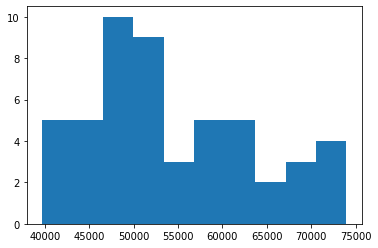

In [0]:
plt.hist([inputs[region]['income'][0] for region in inputs])

In [0]:
def extrapolate_r0(r0, current_population, timespan=[0,1,2,3,4,5,6]):
    infected = np.power(r0, timespan) * current_population
    #plt.plot(infected)
    return infected
#extrapolate_r0(y_pred[-1][0].detach().numpy(), 100)

In [0]:
list(zip(inputs['Michigan']['RtIndicator'], y_pred))

[(1.5, tensor(1.4215, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.4188, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.4345, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.6186, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.4126, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.3417, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.5443, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.4663, grad_fn=<SelectBackward>)),
 (1.5, tensor(1.5986, grad_fn=<SelectBackward>)),
 (1.34, tensor(1.7879, grad_fn=<SelectBackward>)),
 (3.6, tensor(3.3485, grad_fn=<SelectBackward>)),
 (3.38, tensor(3.3086, grad_fn=<SelectBackward>)),
 (2.29, tensor(2.3098, grad_fn=<SelectBackward>)),
 (2.15, tensor(2.2105, grad_fn=<SelectBackward>)),
 (2.04, tensor(2.2323, grad_fn=<SelectBackward>)),
 (2.12, tensor(2.2623, grad_fn=<SelectBackward>)),
 (2.36, tensor(2.2564, grad_fn=<SelectBackward>)),
 (2.32, tensor(2.2779, grad_fn=<SelectBackward>)),
 (2.36, tensor(2.3256, grad_fn=<SelectBackward>)),
 (2.32, tensor(2.2340, grad_fn=<SelectBac